# Mój grid search 2 do logs: python + deep learning + postgresql

In [1]:
import sys
from time import sleep

import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Softmax, Activation, Dropout
from keras.activations import relu
from keras.initializers import VarianceScaling
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.wrappers import scikit_learn

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import psycopg2
import psycopg2.extras # cursor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid") 

Using TensorFlow backend.


In [2]:
# Try to connect
conn = psycopg2.connect(host='192.168.0.101', user='bartek', password='Aga', database='logs', port=5432)
conn.set_client_encoding('UTF8')
cur = conn.cursor()

In [3]:
logs_df = pd.read_sql_query('select * from akuratne_25k', conn)
print(logs_df.shape)
logs_df.head() 

(25113, 11)


,lo_ip,entered,lo_id,rank_w_ip,avg_id,avg_id_rows_current,id_parity,rank_w_ip_parity,the_same_parity,target_1,target_2
0,192.168.0.10,2014-09-22 17:39:48.455371,17,1,2722.206107,17.000000,0,0,1,0,0
1,192.168.0.10,2014-09-22 18:11:32.239572,19,2,2722.206107,18.000000,0,1,0,0,0
2,192.168.0.10,2014-09-22 18:12:17.802802,20,3,2722.206107,18.666667,1,0,0,0,0
3,192.168.0.10,2014-09-22 18:13:14.584192,21,4,2722.206107,19.250000,0,1,0,0,0
4,192.168.0.10,2014-09-22 20:19:33.028606,27,5,2722.206107,20.800000,0,0,1,0,0


In [4]:
print(logs_df.shape)

features = ['rank_w_ip' , 'avg_id_rows_current' , 'id_parity' , 'rank_w_ip_parity' , 'the_same_parity']
features 

(25113, 11)


['rank_w_ip',
 'avg_id_rows_current',
 'id_parity',
 'rank_w_ip_parity',
 'the_same_parity']

In [5]:
target = 'target_1'
y = logs_df[target]

X = logs_df[features]
X.head() 

,rank_w_ip,avg_id_rows_current,id_parity,rank_w_ip_parity,the_same_parity
0,1,17.000000,0,0,1
1,2,18.000000,0,1,0
2,3,18.666667,1,0,0
3,4,19.250000,0,1,0
4,5,20.800000,0,0,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=324)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(20090, 5) (5023, 5) (20090,) (5023,)


In [7]:
scaler = StandardScaler().fit(X_train)

# std scaler jest szkolony tylko na train
# wszelkie przetwarzanie testu na podstawie regół, znalezioych dla train, także dla pre-process
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [8]:
X_train_scaled.shape

(20090, 5)

In [9]:
models = {}

In [10]:
def fit_and_evaluate_model(models, model_id=0, lr=0.001, batch_size=1024, epochs=3500):

    # Keras model
    k_model = Sequential()
    # 1st layer
    #k_model.add(Dense(units=512, kernel_initializer=VarianceScaling, input_shape=X.shape[0], activation=None))
    k_model.add(Dense(128, activation=None, input_shape=(5, )))
    k_model.add(BatchNormalization())
    k_model.add(Activation("relu"))
    k_model.add(Dropout(rate=0.1))
    # 2nd layer
    k_model.add(Dense(64, activation=None))
    k_model.add(BatchNormalization())
    k_model.add(Activation("relu"))
    k_model.add(Dropout(rate=0.1))
    # 3nd layer
    k_model.add(Dense(16, activation=None))
    k_model.add(BatchNormalization())
    k_model.add(Activation("relu"))
    # 4nd layer
    k_model.add(Dense(1, activation=None))
    k_model.add(BatchNormalization())
    k_model.add(Activation("sigmoid"))

    k_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=lr), metrics=["accuracy"])

    # Train
    history = k_model.fit(X_train_scaled, y=y_train.values, epochs=epochs, batch_size=batch_size, validation_split=0.25, verbose=0)

    # Plot training history
    import matplotlib.pyplot as plt
    import seaborn as sns

    %matplotlib inline
    sns.set_style("darkgrid")

    def plot_accuracy_and_loss(trained_model, test_accuracy):

        validation = False

        hist = trained_model.history
        acc = hist['acc']
        loss = hist['loss']
        try:
            val_acc = hist['val_acc']
            val_loss = hist['val_loss']
            validation = True
        except KeyError as e:
            print("No validation data defined, showing only training set hostory")
        epochsw = range(1, len(acc)+1)

        fig, ax = plt.subplots(1,2, figsize=(14,6))

        plt.suptitle("Model_id={0}: lr={1}, batch_size={2}, epochs={3}, test_accuracy={4: .10f}" \
                     .format(model_id, lr, batch_size, epochs, test_accuracy), color='grey', fontsize=20)

        ax[0].tick_params(colors="grey")
        ax[0].plot(epochsw, acc, 'g', label='Training accuracy')
        if validation:
            ax[0].plot(epochsw, val_acc, 'r', label='Validation accuracy')
        ax[0].set_ylabel('Accuracy', color='grey', fontsize=12)
        ax[0].set_title('Training and validation accuracy', color='grey', fontsize=16)
        ax[0].set_xlabel('Epochs', color='grey', fontsize=12)


        ax[0].legend()
        ax[0].grid(True)

        ax[1].tick_params(colors="grey")
        ax[1].plot(epochsw, loss, 'g', label='Training cost')
        if validation:
            ax[1].plot(epochsw, val_loss, 'r', label='Validation cost')
        ax[1].legend()
        ax[1].set_title('Training and validation loss', color='grey', fontsize=16)
        ax[1].set_xlabel('Epochs', color='grey', fontsize=12)
        ax[1].set_ylabel('Loss', color='grey', fontsize=12)
        ax[1].grid(True)

        plt.show()


    # Evaluate & Plot
    score_test = k_model.evaluate(X_test_scaled, y_test, verbose=0)
    test_loss = score_test[0]
    test_accuracy = score_test[1]

    # Print evaluation results on test dataset
    print("model_id_{}: lr={}, batch_size={}, epochs={}".format(model_id, lr, batch_size, epochs))
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)

    # Zapisanie do dictionary
    models["{}".format(model_id)] = {
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
            
    global conn
    global cur

    try:

        # insert statement
        sql_statement = """
            insert into dl_models (python_model_id, lr, batch_size, epochs, test_loss, test_accuracy) values ({}, {}, {}, {}, {}, {})
        """.format(model_id, lr, batch_size, epochs, test_loss, test_accuracy)

        # execute and commit
        cur.execute(sql_statement)
        conn.commit()

    except Exception:
        print("Cannot save model parameters to the database")
        print(str(Exception))

        print("Trying to re-establish database connection...")
        try:
            cur.close()
            conn.close()
        except:
            print("Cannot close current connection")

        # Wait 5s and try re-establish connection
        sleep(5)

        try:
            conn = psycopg2.connect(host='192.168.0.101', user='bartek', password='Aga', database='logs', port=5432)
            conn.set_client_encoding('UTF8')
            cur = conn.cursor()
            print("New connection has been established")
        except:
            print ("I am unable to connect to the database.")

            sleep(180)
            try:
                conn = psycopg2.connect(host='192.168.0.101', user='bartek', password='Aga', database='logs', port=5432)
                conn.set_client_encoding('UTF8')
                cur = conn.cursor()
                print("New connection has been established")
            except:
                print ("I am unable to connect to the database, quitting...")
                sys.exit()

        cur.execute(sql_statement)
        conn.commit()



    # Best model?
    current_best =  models.get("best", None)
    if current_best != None and current_best["test_accuracy"] >= test_accuracy:
        pass

    else:
        # aktualizacja best
        models["best"] = {
            "model_id": model_id,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        }
        # nowy wykres z historią uczenia
        plot_accuracy_and_loss(history,  test_accuracy)

## Final models / tuning

Finalne modele, parametry po analizie wyników z wszystkich 3 kompów: dane z parametrami i oszacowaniem każdego modelu na zbiorze testowym są w bazie logs. Poniżej dłuższy trening na mniejszym learning rate i większych batch_sizes (odwrotne ustawienie testowane na WIN i GPU, skrypty w Spider)

### Finalny trening na mniejszym learning rate i większych batch_sizes




Fitting model 2100 / 2429
model_id_2100: lr=0.0007, batch_size=8192, epochs=10300
Test loss: 0.023349614436425775
Test accuracy: 0.9908421260413957


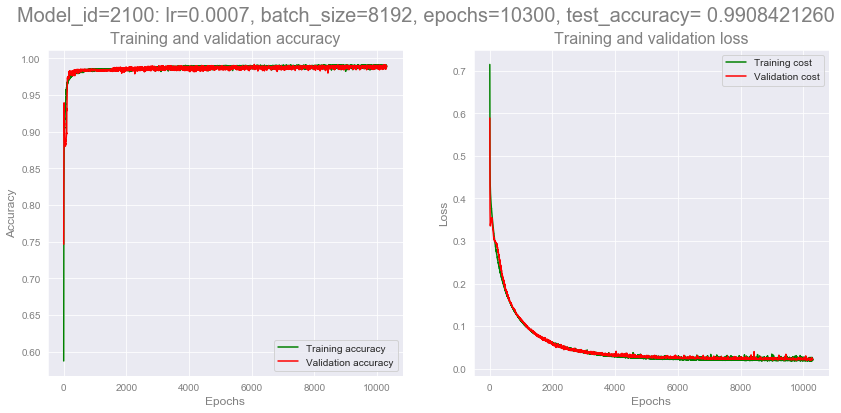



Fitting model 2101 / 2429
model_id_2101: lr=0.0007, batch_size=16384, epochs=10300
Test loss: 0.02781638298528545
Test accuracy: 0.9874576946166842


Fitting model 2102 / 2429
model_id_2102: lr=0.0007, batch_size=8192, epochs=10350
Test loss: 0.02259313973827907
Test accuracy: 0.9886521998924158


Fitting model 2103 / 2429
model_id_2103: lr=0.0007, batch_size=16384, epochs=10350
Test loss: 0.034716172625516344
Test accuracy: 0.9854668524904648


Fitting model 2104 / 2429
model_id_2104: lr=0.0007, batch_size=8192, epochs=10400
Test loss: 0.02322567705253761
Test accuracy: 0.9906430418287737


Fitting model 2105 / 2429
model_id_2105: lr=0.0007, batch_size=16384, epochs=10400
Test loss: 0.025225718476941758
Test accuracy: 0.9892494525302816


Fitting model 2106 / 2429
model_id_2106: lr=0.0007, batch_size=8192, epochs=10450
Test loss: 0.023660812761579705
Test accuracy: 0.9892494523404202


Fitting model 2107 / 2429
model_id_2107: lr=0.0007, batch_size=16384, epochs=10450
Test loss: 0.02

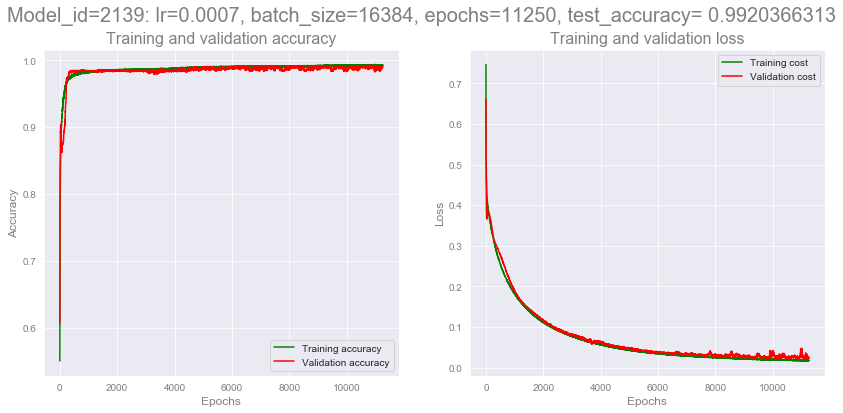



Fitting model 2140 / 2429
model_id_2140: lr=0.0007, batch_size=8192, epochs=11300
Test loss: 0.023628695430847786
Test accuracy: 0.9900457891909079


Fitting model 2141 / 2429
model_id_2141: lr=0.0007, batch_size=16384, epochs=11300
Test loss: 0.025102515923900955
Test accuracy: 0.9900457891909079


Fitting model 2142 / 2429
model_id_2142: lr=0.0007, batch_size=8192, epochs=11350
Test loss: 0.021875781008872483
Test accuracy: 0.9894485367429036


Fitting model 2143 / 2429
model_id_2143: lr=0.0007, batch_size=16384, epochs=11350
Test loss: 0.027298131416619072
Test accuracy: 0.9902448735933913


Fitting model 2144 / 2429
model_id_2144: lr=0.0007, batch_size=8192, epochs=11400
Test loss: 0.0217660301022503
Test accuracy: 0.9906430420186352


Fitting model 2145 / 2429
model_id_2145: lr=0.0007, batch_size=16384, epochs=11400
Test loss: 0.024681670562681772
Test accuracy: 0.9904439578060132


Fitting model 2146 / 2429
model_id_2146: lr=0.0007, batch_size=8192, epochs=11450
Test loss: 0.02

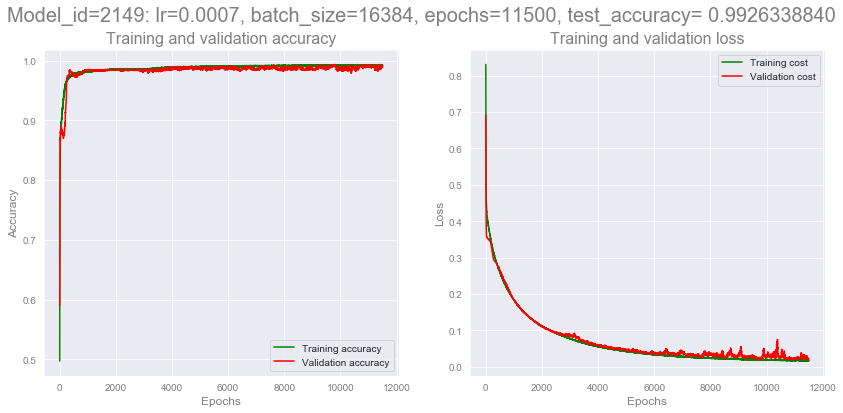



Fitting model 2150 / 2429
model_id_2150: lr=0.0007, batch_size=8192, epochs=11550
Test loss: 0.022919561023275654
Test accuracy: 0.9906430418287737


Fitting model 2151 / 2429
model_id_2151: lr=0.0007, batch_size=16384, epochs=11550
Test loss: 0.05709841941163855
Test accuracy: 0.9812860840254041


Fitting model 2152 / 2429
model_id_2152: lr=0.0007, batch_size=8192, epochs=11600
Test loss: 0.029805747540289414
Test accuracy: 0.9898467051681474


Fitting model 2153 / 2429
model_id_2153: lr=0.0007, batch_size=16384, epochs=11600
Test loss: 0.024472659583908617
Test accuracy: 0.9902448734035298


Fitting model 2154 / 2429
model_id_2154: lr=0.0007, batch_size=8192, epochs=11650
Test loss: 0.023511216996792757
Test accuracy: 0.9882540312773105


Fitting model 2155 / 2429
model_id_2155: lr=0.0007, batch_size=16384, epochs=11650
Test loss: 0.024344148665737777
Test accuracy: 0.9918375471045053


Fitting model 2156 / 2429
model_id_2156: lr=0.0007, batch_size=8192, epochs=11700
Test loss: 0.0

In [ ]:
# grid
lrs = [0.0007]
epochss = [i for i in range(10300, 18550, 50)]
batch_sizes = [8192, 16384]

# last trained model in all machines (will be incremented to assign new python_model_id
model_id = 2099

kombinacje = len(lrs) * len(epochss) * len(batch_sizes) + model_id

for lr in lrs:
    for epochs in epochss:
        for batch_size in batch_sizes:
            model_id += 1
            print("\n\nFitting model {} / {}".format(model_id, kombinacje))
            fit_and_evaluate_model(models, model_id, lr=lr, batch_size=batch_size, epochs=epochs)

            
print("\n\nBest model:")
print(models["best"])



In [ ]:
cur.close()
conn.close()

In [ ]:
import xgboost as xgb